In [1]:
import os 
os.chdir('/lustre/scratch/kiviaho/prostate_spatial/')

import scanpy as sc
import numpy as np
import squidpy as sq
import pandas as pd
import anndata as ad

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scripts.utils import load_from_pickle, get_sample_ids_reorder, get_sample_crop_coords, get_sample_id_mask, save_to_pickle, get_treatment_info
from datetime import datetime   
from scipy.stats import ttest_ind

import seaborn as sns
sns.set_theme(style='white')

from scipy.stats import spearmanr
from statsmodels.stats.multitest import fdrcorrection
from pathlib import Path

from scipy.stats import zscore

import warnings
warnings.filterwarnings("ignore")

samples = get_sample_ids_reorder(['BPH','untreated','bicalutamide','goserelin','CRPC'])
sample_crop_coord = get_sample_crop_coords()
sample_id_masks = get_sample_id_mask()



## Data downloads

In [2]:
# Download the slides dictionary object
adata_slides = load_from_pickle('./data/slides_with_cell_mapping_based_regions.pkl')


In [3]:
# Sort out the regions and their colors

# Get unique region names
regions = adata_slides[samples[5]].obs['predicted_region'].cat.categories.tolist()

# Get unique regions colors
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']

# Rename regions in the data
replace_dict = {'Interferon signaling epithelium':'Intermediate epithelium','Lymphocyte':'Immune'}
for i,r in enumerate(regions):
    if r in replace_dict.keys():
        regions[i] = replace_dict[r]

for sample in samples:
    adata_slides[sample].obs['predicted_region'] = adata_slides[sample].obs['predicted_region'].replace(replace_dict)

# Create color legends
region_colors = adata_slides[samples[5]].uns['predicted_region_colors']
color_dict = dict(zip(regions,region_colors))


In [4]:
# Concatenate slide observations and save them into a single dataframe
# Categorize the obs columns and save them into the dataframe

all_obs = ad.concat(adata_slides).obs.copy()
all_obs['predicted_region'] = all_obs['predicted_region'].astype('category').cat.set_categories(regions)
all_obs['sample_id'] = all_obs['sample_id'].astype('category').cat.set_categories(samples)

# Get the masked id
treat_info = get_sample_id_mask()
masked_ids = list(treat_info.values())
all_obs['masked_id'] = all_obs['sample_id'].map(treat_info).cat.set_categories(masked_ids)

# Add sample class category column
classes = ['BPH','TRNA','NEADT','CRPC']
all_obs['sample_class'] = pd.Categorical(s.split(' ')[0] for s in all_obs['masked_id']).set_categories(classes)

sample_class_dict = all_obs[['sample_id','sample_class']].groupby('sample_id').first().to_dict()['sample_class']


## Expression z-scores (Figure 3 d, supplementary)

In [49]:
# Fetch normalized expression and percentage of spots that express any given gene

def fetch_region_normalized_expression_and_percentage(gene_markers, sample_list, group_id ,slides = adata_slides, regions_list = regions, use_unnormalized = True):
    '''
    Returns the per-sample mean expression of genes of interest across all samples that are defined in sample_list
    inside a region defined by region parameter.
    '''

    final_expression_df = pd.DataFrame()
    final_percentage_df = pd.DataFrame()
    for region in regions_list:

        region_expression_df = pd.DataFrame()
        region_pct_df = pd.DataFrame()

        for sample in sample_list:
            
            slide_subs = slides[sample][slides[sample].obs['predicted_region']==region].copy()

            # Control for the number of data points belonging to a class
            if slide_subs.shape[0] >= 10:
                
                present_genes = [g for g in gene_markers if g in slide_subs.var_names]
                missing_genes = [g for g in gene_markers if g not in slide_subs.var_names]

                genes_all_arr_order_match = present_genes + missing_genes

                if use_unnormalized:
                    expr_without_missing_genes = slide_subs[:,present_genes].layers['counts'].copy().todense()
                else:
                    expr_without_missing_genes = slide_subs[:,present_genes].X.copy()


                expr_all_spots = np.concatenate((expr_without_missing_genes,np.full((expr_without_missing_genes.shape[0],len(missing_genes)), np.nan)),axis=1)

                expr_as_df = pd.DataFrame(data=expr_all_spots.T,index=genes_all_arr_order_match,columns=slide_subs.obs_names)
                expr_as_df = expr_as_df.loc[gene_markers]
                
                # Concatenate the counts from a single sample into a dataframe with all the spots
                region_expression_df = pd.concat([region_expression_df,expr_as_df],axis=1)

                # Put the "percentage of spots expressed in" information into a dataframe
                pct_expressed_in = (expr_as_df != 0).sum(axis=1) / expr_as_df.shape[1]

                # Concatenate the percentage information of each sample into a datframe
                region_pct_df = pd.concat([region_pct_df,pct_expressed_in],axis=1)

        # Here you concatenate the mean of all valid spots into a dataframe
        final_expression_df = pd.concat([final_expression_df,region_expression_df.mean(axis=1)],axis=1)
        final_percentage_df = pd.concat([final_percentage_df,region_pct_df.mean(axis=1)],axis=1)

    final_expression_df.columns = [r + ' ' + group_id for r in regions_list]
    final_percentage_df.columns = [r + ' ' + group_id for r in regions_list]
    return(final_expression_df, final_percentage_df)



def fetch_region_wide_gene_expression(gene_markers, sample_list, slides = adata_slides, regions_list = regions, use_unnormalized = False):
    '''
    Returns the per-sample mean expression of genes of interest across all samples that are defined in sample_list
    inside a region defined by region parameter.
    '''

    final_expression_df = pd.DataFrame()

    for region in regions_list:

        region_expression_df = pd.DataFrame()
        for sample in sample_list:
            
            slide_subs = slides[sample][slides[sample].obs['predicted_region']==region].copy()

            # Control for the number of data points belonging to a class
            if slide_subs.shape[0] >= 10:
                    
                present_genes = [g for g in gene_markers if g in slide_subs.var_names]
                missing_genes = [g for g in gene_markers if g not in slide_subs.var_names]

                genes_all_arr_order_match = present_genes + missing_genes

                if use_unnormalized:
                    expr_without_missing_genes = slide_subs[:,present_genes].layers['counts'].copy().todense()
                else:
                    expr_without_missing_genes = slide_subs[:,present_genes].X.copy()


                expr_all_spots = np.concatenate((expr_without_missing_genes,np.full((expr_without_missing_genes.shape[0],len(missing_genes)), np.nan)),axis=1)

                expr_as_df = pd.DataFrame(data=expr_all_spots.T,index=genes_all_arr_order_match,columns=slide_subs.obs_names)
                expr_as_df = expr_as_df.loc[gene_markers]

                region_expression_df = pd.concat([region_expression_df,expr_as_df],axis=1)

        print(region + ' done')
        final_expression_df = pd.concat([final_expression_df,region_expression_df.mean(axis=1)],axis=1)
    
    final_expression_df.columns = regions_list
    return(final_expression_df)


In [7]:
# Get lists of samples in corresponding groupings
normal_samples = get_sample_ids_reorder(['BPH'])
unt_samples = get_sample_ids_reorder(['untreated'])
trt_samples = get_sample_ids_reorder(['bicalutamide','goserelin'])
crpc_samples = get_sample_ids_reorder(['CRPC'])


### Chemokine signaling heatmap with treatment effect (Figure 4c)

In [20]:
chemokine_markers = pd.read_csv('./chemokine_signaling_genes.csv',sep=';')

markers_to_drop = ['CCL1','CCL12','CCL6','CCL9','CCR8']
chemokine_markers = chemokine_markers.drop(index=np.where(chemokine_markers['gene'].isin(markers_to_drop))[0]).reset_index(drop=True)
chemokine_markers


In [8]:
chemokine_markers_list = chemokine_markers['gene'].unique().tolist()

normal = fetch_region_wide_gene_expression(chemokine_markers_list, normal_samples)
untreated = fetch_region_wide_gene_expression(chemokine_markers_list, unt_samples)
treated = fetch_region_wide_gene_expression(chemokine_markers_list, trt_samples)

cytokine_expression_df = pd.concat([normal,untreated,treated],axis=1).T
cytokine_expression_df.to_csv('data/cytokine_expression_split_by_treatment_tampere_cohort.csv')

Tumor done
Luminal epithelium done
Basal epithelium done
Intermediate epithelium done
Immune done
Endothelium done
Fibroblast done
Muscle done
Tumor done
Luminal epithelium done
Basal epithelium done
Intermediate epithelium done
Immune done
Endothelium done
Fibroblast done
Muscle done
Tumor done
Luminal epithelium done
Basal epithelium done
Intermediate epithelium done
Immune done
Endothelium done
Fibroblast done
Muscle done


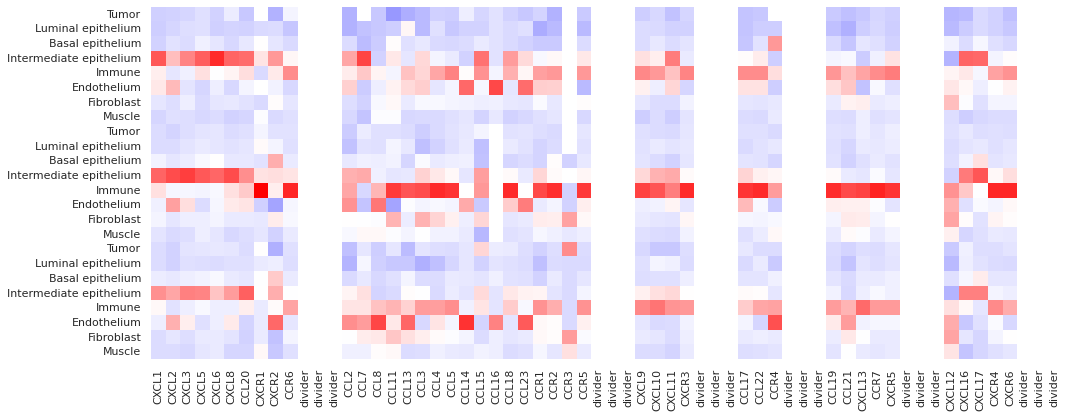

In [16]:
from scipy.stats import zscore

sns.set_theme(style='white')
plot_df = cytokine_expression_df.copy()
plot_df = plot_df.apply(lambda x: zscore(x, nan_policy='omit'))

# Set nan dividers into the gene order to prohibit extensive editing in affinity designer
plot_df['divider'] = np.nan

new_idx = []
ctypes = chemokine_markers['cell type'].unique()
for ct in ctypes:
    lst = chemokine_markers[chemokine_markers['cell type'] == ct]['gene'].tolist()
    new_idx = new_idx + lst + ['divider','divider','divider']
    
plot_df = plot_df[new_idx]

# Set figure size
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the heatmap
sns.heatmap(plot_df, center=0, cmap='bwr', square=True, ax=ax,cbar=False)

# Display the plot
plt.tight_layout()
plt.savefig('plots/normalized_gene_expression_heatmaps/chemokine_signaling_key_genes_broad.pdf')
plt.show()


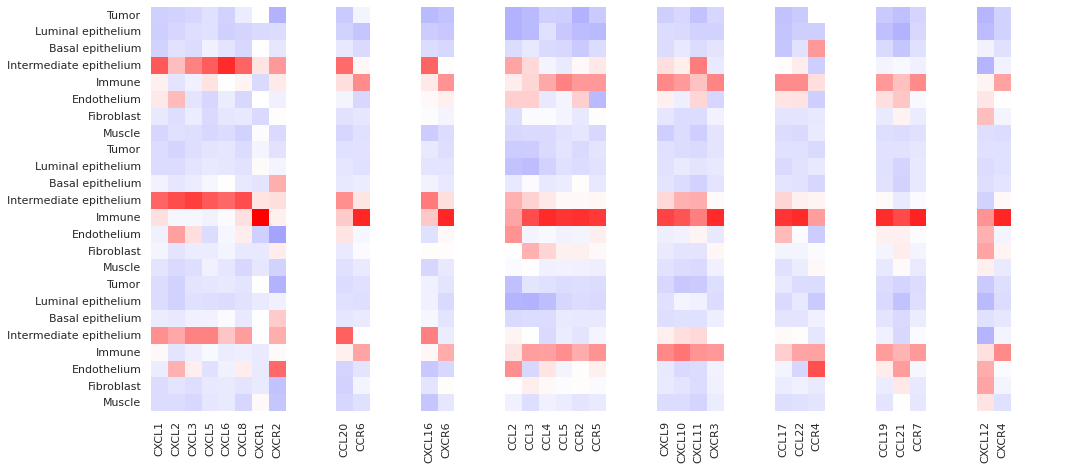

In [27]:
markers_to_keep = ['CXCL1','CXCL2','CXCL3','CXCL5','CXCL6','CXCL8','CXCR1','CXCR2',
                    'CCL2','CCL3','CCL4','CCL5','CCR2','CCR5',
                    'CXCL9','CXCL10','CXCL11','CXCR3',
                    'CCL17','CCL22','CCR4',
                    'CCL19','CCL21','CCR7',
                    'CCL20','CCR6',
                    'CXCL12','CXCR4',
                    'CXCL16','CXCR6'
                    ]

chemokine_markers_filtered = chemokine_markers[chemokine_markers['gene'].isin(markers_to_keep)]

from scipy.stats import zscore

sns.set_theme(style='white')
plot_df = cytokine_expression_df.copy()
plot_df = plot_df.apply(lambda x: zscore(x, nan_policy='omit'))

# Set nan dividers into the gene order to prohibit extensive editing in affinity designer
plot_df[''] = np.nan

new_idx = []
ctypes = chemokine_markers_filtered['cell type'].unique()
for ct in ctypes:
    lst = chemokine_markers_filtered[chemokine_markers_filtered['cell type'] == ct]['gene'].tolist()
    new_idx = new_idx + lst + ['','','']
    
plot_df = plot_df[new_idx]

# Set figure size
fig, ax = plt.subplots(figsize=(15, 10))

# Plot the heatmap
sns.heatmap(plot_df, center=0, cmap='bwr', square=True, ax=ax,cbar=False)

# Display the plot
plt.tight_layout()
plt.savefig('plots/normalized_gene_expression_heatmaps/chemokine_signaling_key_genes_filtered.pdf')
plt.show()


### Chemkine signaling dotplot (3c?)



In [119]:
chemokine_marker_genes = [
                    'CEBPB','NFKB1','IL1RN','CD68','PLAUR','div0',
                    'CXCL1','CXCL2','CXCL3','CXCL5','CXCL6','CXCL8','CXCR1','CXCR2','div1',
                    'CXCL16','CXCR6','div2',
                    'CCL20','CCR6','div3',
                    'CCL2','CCL3','CCL4','CCL5','CCR2','CCR5','div4',
                    'CXCL9','CXCL10','CXCL11','CXCR3','div5',
                    'CCL17','CCL22','CCR4','div6',
                    'CCL19','CCL21','CCR7','div7',
                    'CXCL12','CXCR4'
                    ]

#expr_normal, pct_normal = fetch_region_normalized_expression_and_percentage(ar_signaling_genes, normal_samples, group_id='(BPH)', regions_list=regions[:4])
expr_unt, pct_unt = fetch_region_normalized_expression_and_percentage(chemokine_marker_genes, unt_samples,group_id='(TRNA)',regions_list=regions)
expr_trt, pct_trt = fetch_region_normalized_expression_and_percentage(chemokine_marker_genes, trt_samples,group_id='(NEADT)',regions_list=regions)
#expr_crpc, pct_crpc = fetch_region_normalized_expression_and_percentage(ar_signaling_genes, crpc_samples,regions_list=regions[:4])


In [120]:

#plot_df = pd.concat([normal_ar,untreated_ar,treated_ar,crpc_ar],axis=1).T
expr_df = pd.concat([expr_unt,expr_trt],axis=1).T
pct_df = pd.concat([pct_unt,pct_trt],axis=1).T
expr_df = expr_df.apply(lambda x: zscore(x, nan_policy='omit'))
regions_mod = expr_df.index.tolist()

# Format to long
plot_df = expr_df.melt(ignore_index=False)
plot_df.columns = ['gene','expression']

# Format to long
pct_df = pct_df.melt(ignore_index=False)
pct_df.columns = ['gene','percentage']

plot_df['percentage'] = pct_df['percentage'].copy()

plot_df = plot_df.reset_index(names='region')

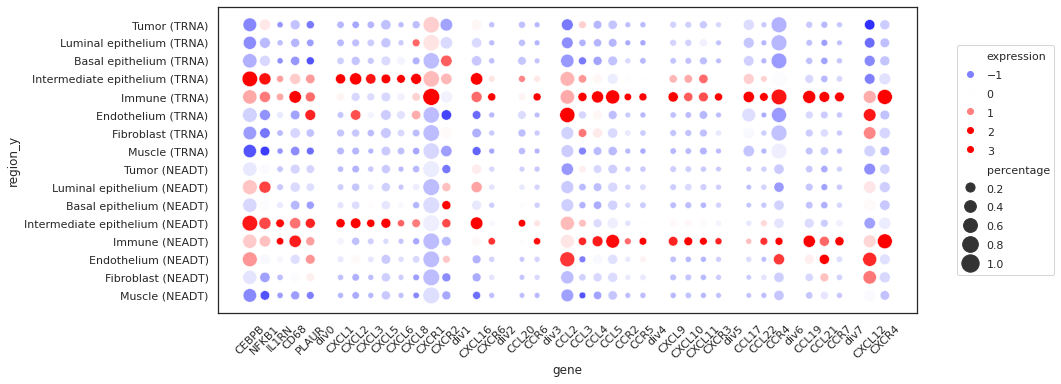

In [136]:

# Create the dotplot
sns.set(style='white')

width = 15
height = 5.5

fig, ax = plt.subplots(figsize=(width, height))
yticks_list = list(np.arange(2,(len(regions_mod)*2)+2,2)[::-1])


# Get control over interactions order and gap
plot_df['region_y'] = plot_df['region'].map(dict(zip(regions_mod,yticks_list)))
sns.scatterplot(x='gene', y='region_y', size='percentage', hue='expression', 
                hue_norm=(-2,2),data=plot_df, sizes=(30, 300), palette='bwr', ax=ax,legend=True,
                )

plt.ylim(0,yticks_list[0]+2)
plt.yticks(yticks_list,regions_mod)
plt.xticks(rotation=45)
plt.legend(loc='center left',handlelength=1.5, handleheight=1.5, bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()

plt.savefig('plots/normalized_gene_expression_heatmaps/chemokine_markers_expression_dotplot.pdf',transparent=True)

plt.show()


### AR-signaling associated genes dotplot (2b)



In [75]:
ar_signaling_genes = ['AR','ABCC4','FKBP5','KLK3','MAF','NKX3-1','PMEPA1','div1', # AR regulated genes
 'KRT5','KRT15','TP63','div2', # Canonical basal markers
 'MMP7','PIGR','LTF','div3', # Club-like markers
 'KRT4','PSCA','CLU','KRT19','KLF5','S100A11','ATP1B1', # Putative stemness-type markes # 'CYP2F1','TSPAN8','ANXA3','PPP1R1B','KRT8', (Baures et al. Cancers 2022)
 'EGFR','MET' # Putative stemness-type receptors #,'IGF1R','ERBB4','ERBB2'
 ] 

In [76]:
#expr_normal, pct_normal = fetch_region_normalized_expression_and_percentage(ar_signaling_genes, normal_samples, group_id='(BPH)', regions_list=regions[:4])
expr_unt, pct_unt = fetch_region_normalized_expression_and_percentage(ar_signaling_genes, unt_samples,group_id='(TRNA)',regions_list=regions[:4])
expr_trt, pct_trt = fetch_region_normalized_expression_and_percentage(ar_signaling_genes, trt_samples,group_id='(NEADT)',regions_list=regions[:4])
#expr_crpc, pct_crpc = fetch_region_normalized_expression_and_percentage(ar_signaling_genes, crpc_samples,regions_list=regions[:4])


In [93]:

#plot_df = pd.concat([normal_ar,untreated_ar,treated_ar,crpc_ar],axis=1).T
expr_df = pd.concat([expr_unt,expr_trt],axis=1).T
pct_df = pd.concat([pct_unt,pct_trt],axis=1).T
expr_df = expr_df.apply(lambda x: zscore(x, nan_policy='omit'))
regions_mod = expr_df.index.tolist()

# Format to long
plot_df = expr_df.melt(ignore_index=False)
plot_df.columns = ['gene','expression']

# Format to long
pct_df = pct_df.melt(ignore_index=False)
pct_df.columns = ['gene','percentage']

plot_df['percentage'] = pct_df['percentage'].copy()

plot_df = plot_df.reset_index(names='region')

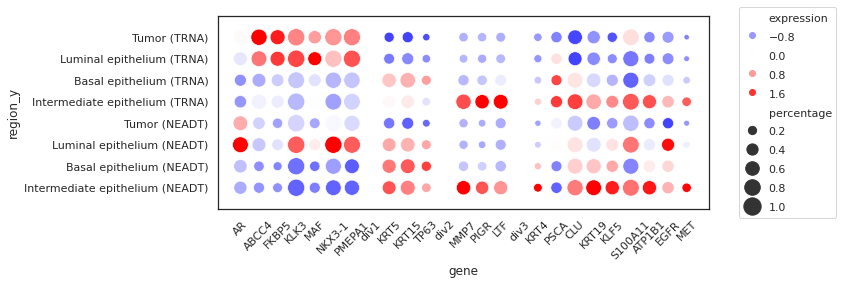

In [96]:

# Create the dotplot
sns.set(style='white')

width = 12
height = 4

fig, ax = plt.subplots(figsize=(width, height))
yticks_list = list(np.arange(2,(len(regions_mod)*2)+2,2)[::-1])


# Get control over interactions order and gap
plot_df['region_y'] = plot_df['region'].map(dict(zip(regions_mod,yticks_list)))
sns.scatterplot(x='gene', y='region_y', size='percentage', hue='expression', 
                hue_norm=(-2,2),data=plot_df, sizes=(30, 300), palette='bwr', ax=ax,legend=True,
                )

plt.ylim(0,yticks_list[0]+2)
plt.yticks(yticks_list,regions_mod)
plt.xticks(rotation=45)
plt.legend(loc='center left',handlelength=1.5, handleheight=1.5, bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()

#plt.savefig('plots/normalized_gene_expression_heatmaps/ar_club_markers_expression.pdf')

plt.show()


## Sample proportion swarmplots (Figure 3a)

In [15]:
from scripts.utils import get_treatment_info

treat_info = get_treatment_info()
concat_obs = all_obs.copy()
concat_obs['treatment'] = concat_obs['sample_id'].map(treat_info)

def get_spot_proportions(region,sample_list=samples,slides=adata_slides,treatment_info=treat_info):
    df = pd.DataFrame(index=samples,columns=[region + ' spots','total spots','treatment'])
    for sample in sample_list:
        df.loc[sample,'total spots'] = len(adata_slides[sample])
        df.loc[sample,region + ' spots'] = len(slides[sample][slides[sample].obs['predicted_region'] == region])
    df['proportion'] = df[region+' spots'] / df['total spots']
    df['treatment'] = df.index.map(treatment_info)

    # Re-annotate
    df['treatment'] = df['treatment'].replace({'bicalutamide':'treated','goserelin':'treated'})

    df['treatment'] = df['treatment'].astype('category')    
    df['proportion'] = df['proportion'].astype(float)

    return(df)


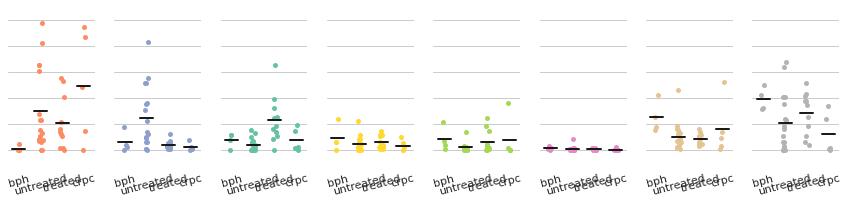

In [42]:
sns.set_theme(style='whitegrid')

order = ['bph', 'untreated', 'treated','crpc']

fig, axs = plt.subplots(1,8,figsize=(12,3))
for i, region in enumerate(regions):
    #sns.set_palette(sns.color_palette([color_dict[region]]))    
    #fig, ax = plt.subplots(figsize=(2,3))
    ax = axs[i]
    df = get_spot_proportions(region)

    sns.stripplot(x="treatment", y="proportion", order = order, data=df, size=5, ax=ax, color=color_dict[region]) # color=".7",)
    sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'color': 'k', 'ls': '-', 'lw': 2},
            medianprops={'visible': False},
            whiskerprops={'visible': False},
            zorder=10,
            x="treatment",
            y="proportion",
            data=df,
            order = order,
            showfliers=False,
            showbox=False,
            showcaps=False,
            width=0.6,
            ax=ax)
    ax.set_ylim(-0.1,1.1)
    #ax.set_title(region)
    ax.set_ylabel('')
    ax.set_xlabel('')
    #ax.set_xticklabels([''])
    ax.set_xticklabels(ax.get_xticklabels(),rotation=15)
    ax.set_yticklabels([''])
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig('./plots/region_proportion_swarmplots/all_region_proportions_swarmplot.pdf')
#plt.savefig('./plots/region_proportion_swarmplots/'+region+'_proportions_swarmplot.pdf')
plt.show()

In [40]:
# Perform statistical testing of possible differences in spot proportions between samples
# Use these to draw significance bars on top of the swarmplots

from scipy.stats import kruskal,mannwhitneyu
import scikit_posthocs as sp

for region in regions:
    df = get_spot_proportions(region)
    df['treatment'] = df['treatment'].cat.reorder_categories(['bph','untreated','treated','crpc'])

    # extract the values and categories from the dataframe
    values = df['proportion']
    categories = df['treatment']

    # perform the Kruskal-Wallis test
    statistic, p_value = kruskal(*[values[categories == cat] for cat in set(categories)])

    print(region)
    # print the results
    print("Kruskal-Wallis test")
    print("p-value: {:.3f}".format(p_value))

    if p_value < 0.05:
        treatments = df['treatment'].cat.categories
        res_df = pd.DataFrame(np.eye(len(treatments),len(treatments)),index=treatments,columns=treatments)

        for i in range(len(treatments)):
            for j in range(i+1, len(treatments)):
                # Get data for the two treatments being compared
                data1 = df.loc[df['treatment'] == treatments[i], 'proportion']
                data2 = df.loc[df['treatment'] == treatments[j], 'proportion']
                
                # Perform Mann-Whitney U test
                stat, pval = mannwhitneyu(data1, data2)
                
                # Print results
                res_df.loc[treatments[i],treatments[j]] = pval
                res_df.loc[treatments[j],treatments[i]] = pval
        print('Mann-Whitney U-test:')
        print(res_df)
    print('')

Tumor
Kruskal-Wallis test
p-value: 0.030
Mann-Whitney U-test:
                bph  untreated   treated      crpc
bph        1.000000   0.004771  0.015628  0.105364
untreated  0.004771   1.000000  0.572424  0.492899
treated    0.015628   0.572424  1.000000  0.319597
crpc       0.105364   0.492899  0.319597  1.000000

Luminal epithelium
Kruskal-Wallis test
p-value: 0.016
Mann-Whitney U-test:
                bph  untreated   treated      crpc
bph        1.000000   0.119967  0.949451  0.555556
untreated  0.119967   1.000000  0.011080  0.024607
treated    0.949451   0.011080  1.000000  0.145147
crpc       0.555556   0.024607  0.145147  1.000000

Basal epithelium
Kruskal-Wallis test
p-value: 0.005
Mann-Whitney U-test:
                bph  untreated   treated      crpc
bph        1.000000   0.361571  0.055678  0.904762
untreated  0.361571   1.000000  0.000707  0.358700
treated    0.055678   0.000707  1.000000  0.114927
crpc       0.904762   0.358700  0.114927  1.000000

Intermediate epitheliu

## Differential expression analyses (Figure 2b)

### Calculate differential expression in individual regions and individual samples

In [ ]:
# Calculate DEGs between regions individually in samples
# This takes several minutes with method='wilcoxon',
# About a minute with method='t-test'
for sample in samples:

    slide = adata_slides[sample]#.copy()

    # Remove a group if it has less than 10 spots in it
    val_counts = slide.obs['predicted_region'].value_counts()
    category_groups = val_counts[~(val_counts < 10)].index.tolist()

    sc.tl.rank_genes_groups(slide,groupby='predicted_region', method='wilcoxon',groups=category_groups,random_state=25813063)


In [ ]:
from scripts.utils import get_sample_id_mask
masked_sample_ids = get_sample_id_mask()

# Take a region one at a time, extract DEG results, save into a list

region_degs_dict = {}
for region in regions:
    deg_res_all = pd.DataFrame()

    for sample in samples:

        slide = adata_slides[sample]

        try:
            deg_res = sc.get.rank_genes_groups_df(slide,group=region)

            deg_res = deg_res[~deg_res['names'].str.contains('RPL|RPS')] # Take out ribosomal genes
            deg_res = deg_res[~deg_res['names'].str.startswith('MT')]
            deg_res['sample'] = sample #masked_sample_ids[sample]
            deg_res = deg_res[(deg_res['pvals_adj']<0.05) & (deg_res['logfoldchanges']>=1)].reset_index(drop=True)


            deg_res_all = pd.concat([deg_res_all,deg_res],axis=0)
        except:
            continue

    region_degs_dict[region] = deg_res_all

date = datetime.now().strftime('%y%m%d')

#save_to_pickle(region_degs_dict,'./data/region_gene_markers_signif_degs_'+date+'.pkl')

In [ ]:
region_sample_counts = {}
df_gene_counts = pd.DataFrame()
for r in regions:
    df_gene_counts = pd.merge(region_degs_dict[r]['names'].value_counts().rename(r),df_gene_counts,left_index=True,right_index=True,how='outer')
    region_sample_counts[r] = len(region_degs_dict[r]['sample'].unique())
df_gene_counts = df_gene_counts.fillna(0).astype(int)


### Fisher's exact test of individual gene markers

In [ ]:
# Take DEG results and perform enrichment analysis:
# Check in how many samples this gene is overexpressed in a specific region
# Compare this to how many samples the same gene is overexpressed in 
# If there is a significant enrichment for this marker in a region, it can be considired region specific


from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

signif_pval_interactions = {}

for reg in regions:
    
    df = df_gene_counts.copy()
    other_keys = [c for c in df.columns if c != reg]

    n_sample = region_sample_counts[reg]
    n_control = pd.Series([region_sample_counts[k] for k in other_keys]).sum()

    df = df.sort_index()

    # Perform Fisher's exact test on all 
    for iact in df.index:
        a = df[reg].loc[[iact]]
        c = df[other_keys].sum(axis=1).loc[[iact]]
        b = n_sample-a
        d = n_control-c
        arr = np.array([a,b,c,d]).reshape(2,2).astype(int)
        stat,pval = fisher_exact(arr,alternative='greater')
        df.loc[[iact],'pval'] = pval

    df['adj_pval'] = multipletests(df['pval'],method='fdr_bh')[1]


    df_signif = pd.DataFrame({'interaction':df.index.tolist(),
                                'active_in':df[reg].astype(int).tolist(),
                                'adj_pval':df['adj_pval'].tolist(),
                                'interface':np.repeat(reg,len(df))})

    signif_pval_interactions[reg] = df_signif.copy()


date = datetime.now().strftime('%y%m%d')
save_to_pickle(signif_pval_interactions,'./data/region_gene_markers_fishers_exact_test_'+date+'.pkl')

In [ ]:
# Save the results into an excel-file

# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/supp_table_3.xlsx', engine='xlsxwriter')

# Iterate through each key-value pair in the dictionary
for key, value in region_degs_dict.items():
    # Write each dataframe to a separate sheet in the Excel file
    value['sample'] = value['sample'].map(sample_id_masks)
    value.to_excel(writer, sheet_name=key)

# Save and close the Excel writer
writer.save()


### Create the dotplot and plot it

In [ ]:
# Define gene markers for the dotplot 2b
marker_genes_for_hmap = ['PRAC1','HPN','PCAT14','AMACR','PCA3', # Tumor
                         'MSMB','ACPP','RDH11','NKX3-1','AZGP1', # Luminal
                         'KRT5','KRT15','TRIM29','TP63','SLC14A1', # Basal 
                         'MMP7','PIGR','LTF','CP','KRT7', # Intermediate
                         'CXCR4','TRBC1','CD3D','LYZ','CD79A', # Lymphocyte
                         'EPAS1','EMP1','VWF','PECAM1','IFI27', # Endothelium
                         'DCN','LUM','FBLN1','SFRP2','COL1A1', # Fibroblast
                         'TAGLN','ACTA2','ACTG2','MYH11','MYL9' # Muscle
                         ]

In [ ]:
# Create the dotplot structure

plot_df = pd.DataFrame()
for region in regions:
    degs = region_degs_dict[region]
    n_samples = len(degs['sample'].unique())
    
    degs = degs[degs['names'].isin(marker_genes_for_hmap)]
    
    mean_lfc_list = []
    proportion_degs_list = []

    for gene in marker_genes_for_hmap:

        if gene in degs['names'].values:
            mean_lfc = degs[degs['names'] == gene]['logfoldchanges'].mean()
            proportion_degs = degs['names'].value_counts()[gene] / n_samples
            mean_lfc_list.append(mean_lfc)
            proportion_degs_list.append(proportion_degs)
        
        else:
            mean_lfc_list.append(np.nan)
            proportion_degs_list.append(0)
    
    df = pd.DataFrame({'mean_logfoldchange': mean_lfc_list,'pct_deg_in': proportion_degs_list, 'region': region},index = marker_genes_for_hmap)
    plot_df = pd.concat([plot_df,df],axis=0)

plot_df['genes'] = plot_df.index.astype(str)

plot_df.loc[plot_df['pct_deg_in']==0,'pct_deg_in'] = np.nan

In [ ]:

# Create the dotplot
sns.set(style='white')

width = 18
height = 4

fig, ax = plt.subplots(figsize=(width, height))
yticks_list = list(np.arange(2,(len(regions)*2)+2,2)[::-1])


# Get control over interactions order and gap
plot_df['region_y'] = plot_df['region'].map(dict(zip(regions,yticks_list)))
sns.scatterplot(x='genes', y='region_y', size='pct_deg_in', hue='mean_logfoldchange', 
                data=plot_df, sizes=(40, 400), palette='Reds', ax=ax,legend=True,
                )

plt.ylim(0,yticks_list[0]+2)
plt.yticks(yticks_list,regions)
plt.xticks(rotation=45)
plt.legend(loc='center left',handlelength=1.5, handleheight=1.5, bbox_to_anchor=(1.05, 0.5))
plt.tight_layout()

plt.savefig('./plots/region_gene_markers_dotplot.pdf')
plt.show()


### Miscellaneous supplementary tables

In [ ]:
# Get the number of regions in each sample and save into a dataframe

df = all_obs[['sample_id','predicted_region']].copy()
df['sample_id'] = df['sample_id'].map(sample_id_masks)
df['sample_id']= df['sample_id'].cat.reorder_categories(sample_id_masks.values())
df['count'] = 1
region_counts_df  = df.groupby(['sample_id','predicted_region']).agg({'count':'sum'})
region_counts_df

In [ ]:
# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/region_prevalences_in_all_samples.xlsx', engine='xlsxwriter')

# Write the dataframe into a  Excel file
region_counts_df.to_excel(writer)

# Save and close the Excel writer
writer.save()

In [ ]:
# Reformat rgeion – Fisher's test markers for saving

deg_fishers_res_dict = load_from_pickle('./data/region_gene_markers_fishers_exact_test_231107.pkl')

for reg in regions:

    n_valid_samples = (region_counts_df.loc[region_counts_df.index.get_level_values(1) == reg]['count'] >=10).sum()
    df = deg_fishers_res_dict[reg].copy()

    df = df.drop(columns='interface')
    df.columns = ['gene', 'over-expressed in (out of {:d} region-containing samples)'.format(n_valid_samples), 'adjusted p-value (Fishers exact test)']
    df = df.sort_values('adjusted p-value (Fishers exact test)').reset_index(drop=True)
    deg_fishers_res_dict[reg] = df


In [ ]:
# Save the results into an excel-file
# Create a Pandas Excel writer using the file name
writer = pd.ExcelWriter('./supplementary_tables/supp_table_with_region_marker_fishers.xlsx', engine='xlsxwriter')

# Iterate through each key-value pair in the dictionary
for key, value in deg_fishers_res_dict.items():
    # Write each dataframe to a separate sheet in the Excel file
    value.to_excel(writer, sheet_name=key)

# Save and close the Excel writer
writer.save()

## Spatial plots in a grid (Supplementary)

### Tissue H&E

In [ ]:
sns.set_theme(style='white')
sample_id_mask_dict = get_sample_id_mask()
samples = list(sample_id_mask_dict.keys())

it=0
fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=300)

for i in range(5):
    for j in range(8):
        
        if it < len(samples):
            sc.pl.spatial(adata_slides[samples[it]],color='predicted_region',title=sample_id_mask_dict[samples[it]],
                        crop_coord=sample_crop_coord[samples[it]],
                        size=0, alpha_img=1, legend_loc=None,
                        ax=axs[i,j],show=False
                        )

            axs[i,j].set_xlabel(None)
            axs[i,j].set_ylabel(None)
            it+=1
        else:
            axs[i,j].set_visible(False)

plt.tight_layout()


plt.savefig('./plots/HE_all_samples_spatial.png',dpi=120)
plt.clf()
#plt.show()


### Regions on samples no background individual

In [44]:

for sample in samples:
    
    fig, ax = plt.subplots(figsize=(3,3),dpi=200)

    sc.pl.spatial(adata_slides[sample],color='predicted_region',title=sample_id_mask_dict[sample],
                crop_coord=sample_crop_coord[sample],
                size=1.5, alpha_img=0.0, legend_loc=None, # Old 1.3 and 0.8
                ax=ax,show=False
                )
    plt.tight_layout()


    plt.savefig('./plots/all_samples_grid/region_based/individually/'+sample.replace(' ', '_')+'.pdf')
    plt.clf()
    #plt.show()


<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

### Regions on all samples single grid

In [43]:
import matplotlib.patches as patches

# Create an empty list to store legend handles
legend_handles = []

# Iterate over the dictionary items
for name, color in color_dict.items():
    # Create a colored circle patch
    patch = patches.Patch(color=color, label=name)
    # Add the patch to the legend handles list
    legend_handles.append(patch)

sample_id_mask_dict = get_sample_id_mask()
samples = list(sample_id_mask_dict.keys())


it=0
fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=120)

for i in range(5):
    for j in range(8):
        
        if it < len(samples):
            sc.pl.spatial(adata_slides[samples[it]],color='predicted_region',title=sample_id_mask_dict[samples[it]],
                        crop_coord=sample_crop_coord[samples[it]],
                        size=1.5, alpha_img=0.0, legend_loc=None, # Old 1.3 and 0.8
                        ax=axs[i,j],show=False
                        )

            axs[i,j].set_xlabel(None)
            axs[i,j].set_ylabel(None)
            it+=1
        else:
            axs[i,j].set_visible(False)

plt.tight_layout()

# create custom axes for the annotation legend 
cax1 = fig.add_axes([0.70, 0.03, 0.1, 0.15])
cax2 = fig.add_axes([0.82, 0.03, 0.1, 0.15])

cax1.axis('off')
cax1.legend(handles=legend_handles[:4],loc='center',markerscale=2,fontsize='xx-large')
cax2.axis('off')
cax2.legend(handles=legend_handles[4:],loc='center',markerscale=2,fontsize='xx-large')


plt.savefig('./plots/all_samples_grid/region_based/regions_on_all_samples_spatial.pdf')
plt.clf()
#plt.show()


<Figure size 2880x1800 with 0 Axes>

### Regions one at a time on all samples single grid

In [ ]:

for region_of_interest in regions:
    it=0
    fig, axs = plt.subplots(5, 8, figsize=(24, 15),dpi=120)

    for i in range(5):
        for j in range(8):
            
            if it < len(samples):
                slide = adata_slides[samples[it]].copy()
                slide.obs['region_of_interest'] = np.nan
                slide.obs.loc[slide.obs['predicted_region']==region_of_interest,'region_of_interest'] = region_of_interest

                slide.uns['region_of_interest_colors'] = [color_dict[region_of_interest]]

                slide.obs['region_of_interest'] = slide.obs['region_of_interest'].astype('category')

                try:
                    n_spots = slide.obs['region_of_interest'].value_counts()[region_of_interest]
                except:
                    n_spots=0

                sc.pl.spatial(slide,color='region_of_interest',title=samples[it]+ ' ({:d})'.format(n_spots),
                            crop_coord=sample_crop_coord[samples[it]],
                            size=1.3, alpha_img=0.8, legend_loc=None,na_color='whitesmoke',
                            ax=axs[i,j],show=False
                            )

                axs[i,j].set_xlabel(None)
                axs[i,j].set_ylabel(None)
                it+=1
            else:
                axs[i,j].set_visible(False)

    plt.tight_layout()

    # create custom axes for the annotation legend 
    cax1 = fig.add_axes([0.70, 0.03, 0.1, 0.15])
    cax2 = fig.add_axes([0.82, 0.03, 0.1, 0.15])

    cax1.axis('off')
    cax1.legend(handles=legend_handles[:4],loc='center',markerscale=2,fontsize='x-large')
    cax2.axis('off')
    cax2.legend(handles=legend_handles[4:],loc='center',markerscale=2,fontsize='x-large')


    plt.savefig('./plots/all_samples_grid/'+region_of_interest+'_region_on_all_spatial_sections.pdf')
    plt.clf()
    #plt.show()


### Regions one sample at a time

In [14]:
for sample in samples:
    
    it=0

    fig, axs = plt.subplots(2, 4, figsize=(12, 6),dpi=300)

    slide = adata_slides[sample].copy()

    for i in range(2):
        for j in range(4):
        
            region_of_interest = regions[it]

            if region_of_interest in slide.obs['predicted_region'].unique():
                
                slide.obs['region_of_interest'] = np.nan

                slide.obs.loc[slide.obs['predicted_region']==region_of_interest,'region_of_interest'] = region_of_interest

                slide.uns['region_of_interest_colors'] = [color_dict[region_of_interest]]

                slide.obs['region_of_interest'] = slide.obs['region_of_interest'].astype('category')

            
                n_spots = slide.obs['region_of_interest'].value_counts()[region_of_interest]

                sc.pl.spatial(slide,color='region_of_interest',title=region_of_interest+ ' ({:d})'.format(n_spots),
                        crop_coord=sample_crop_coord[sample],
                        size=1.5, alpha_img=0.0, legend_loc=None,na_color='whitesmoke', # Changed from 0.8
                        ax=axs[i,j],show=False
                        )
                axs[i,j].set_xlabel(None)
                axs[i,j].set_ylabel(None)

            else:
                axs[i,j].set_visible(False)
            
            it+=1
    
    plt.tight_layout()
    plt.savefig('./plots/all_samples_grid/region_based/sample_specific/'+sample+'_all_regions_individually.pdf')
    plt.clf()
    #plt.show()


<Figure size 3600x1800 with 0 Axes>

<Figure size 3600x1800 with 0 Axes>

## Stacked barplot of region proportions on samples + sample mask order (Supplementary)

In [ ]:
df = all_obs[['sample_id','predicted_region']]

# Calculate the proportion of data points in each predicted_region class
counts = df['predicted_region'].value_counts(normalize=True)

# Pivot the dataframe to create a matrix of values
df_pivot = df.pivot_table(index='sample_id', columns='predicted_region', aggfunc='size', fill_value=0)

# Normalize the values in each row
df_norm = df_pivot.div(df_pivot.sum(axis=1), axis=0)

treat_info = get_treatment_info()
for k in list(treat_info.keys()):
    if (treat_info[k] == 'bicalutamide') | (treat_info[k] ==  'goserelin'):
        treat_info[k] = 'neoadjuvant'


df_norm['treatment'] = df_norm.index.map(treat_info)

# Get the sample ids into a order where they are grouped by sample categories, but also decrease in tumor 
# content within categories
stacked_bar_sample_order = []
for trt in df_norm['treatment'].unique():
    stacked_bar_sample_order += df_norm[df_norm['treatment'] == trt].sort_values(['Tumor'],ascending=False).index.tolist()

In [ ]:
# assuming your dataframe is named df
pivot_table = df.groupby('sample_id')['predicted_region'].value_counts(normalize=True).unstack()

# Set the pre-defined order
pivot_table = pivot_table.loc[stacked_bar_sample_order]

# plot the stacked barplot
fig, ax = plt.subplots(figsize=(12,3),dpi=300)
pivot_table.plot.bar(stacked=True, color=region_colors,legend=False,width=0.8,edgecolor='black',ax=ax)

# add labels and title
plt.xlabel('Sample ID Class')
plt.ylabel('Count')
plt.gca().set_yticks([0.2,0.4,0.6,0.8,1.0])

#plt.tight_layout()
plt.savefig('plots/region_proportions_all_samples.pdf')
plt.clf()


In [ ]:
# Save the masking dict in this order

pseoudo_ids = ['BPH ' + str(i) for i in np.arange(1,5)] + ['TRNA ' + str(i) for i in np.arange(1,18)] + ['NEADT ' + str(i) for i in np.arange(1,12)] + ['CRPC ' + str(i) for i in np.arange(1,6)]
masking_dict = dict(zip(stacked_bar_sample_order,pseoudo_ids))
masking_df = pd.DataFrame(masking_dict,index=np.arange(1)).T.reset_index()
masking_df.columns = ['PAD','Pseudo_ID']
masking_df.to_csv('patient_id_mask.csv',sep=';',index=False)

### Barplot with region prevalence (Figure 2d top)

In [ ]:
# Barplot of the numer of spots belonging to each region
concat_obs = pd.DataFrame()
for sample in samples:
    concat_obs = pd.concat([concat_obs,adata_slides[sample].obs.copy()],axis=0)

plt.figure(figsize=(3,3))
barplot_df = concat_obs.predicted_region.value_counts().loc[regions]
barplot_df.plot.bar(color=region_colors,width=1)
plt.axhline(y=10000,linestyle='--',color='black',linewidth=1)
plt.axhline(y=20000,linestyle='--',color='black',linewidth=1)
plt.xticks(rotation=60)
plt.savefig('./plots/region_prevalence_barplot.pdf')